In [22]:
!pip3 install datasets

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from transformers import get_cosine_schedule_with_warmup
import math
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers





In [24]:
class Block(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_expansion=4, dropout=0.1):
        super(Block, self).__init__()
        self.ln_attn = nn.LayerNorm(embed_dim)
        self.ln_ff = nn.LayerNorm(embed_dim)

        # Multi-head attention layer
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)

        # Feedforward
        self.fc1 = nn.Linear(embed_dim, int(ff_expansion * embed_dim))
        self.fc2 = nn.Linear(int(ff_expansion * embed_dim), embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):

        # Pre-layer normalization before self-attention
        x_norm = self.ln_attn(x)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm, attn_mask=attn_mask)

        x = x + self.dropout(attn_output) #residual connection


        x_norm = self.ln_ff(x)
        ff_output = self.fc2(F.gelu(self.fc1(x_norm)))
        x = x + self.dropout(ff_output)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, max_seq_length, embed_dim, num_heads, num_layers, mlp_ratio=4.0, dropout=0.1):
        super(Decoder, self).__init__()
        # Token embeddings and learned position embeddings
        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.position_embed = nn.Embedding(max_seq_length, embed_dim)
        self.dropout = nn.Dropout(dropout)


        self.layers = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, dropout) for i in range(num_layers)
        ])

        # Final layer normalization before output projection
        self.ln_f = nn.LayerNorm(embed_dim)

        # Output head projecting to vocabulary size (tying weights with token_embed is also common)
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)

    def forward(self, input_ids):

        batch_size, seq_length = input_ids.size()
        # Create token and position embeddings
        token_embeddings = self.token_embed(input_ids)
        positions = torch.arange(0, seq_length, device=input_ids.device).unsqueeze(0).expand(batch_size, seq_length)
        position_embeddings = self.position_embed(positions)

        # Combine embeddings and apply dropout
        x = token_embeddings + position_embeddings
        x = self.dropout(x)

        x = x.transpose(0, 1)

        attn_mask = torch.triu(torch.full((seq_length, seq_length), float('-inf'), device=input_ids.device), diagonal=1)

        # Pass through each Transformer block
        for layer in self.layers:
            x = layer(x, attn_mask=attn_mask)

        x = self.ln_f(x).transpose(0, 1)

        # Project to logits over the vocabulary
        logits = self.head(x)

        return logits


In [25]:

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.encoded_texts = [tokenizer.encode(text).ids[:max_length] for text in texts if text.strip()]

    def __len__(self):
        return len(self.encoded_texts)

    def __getitem__(self, idx):
        tokens = self.encoded_texts[idx]
        input_ids = torch.tensor(tokens[:-1], dtype=torch.long)
        target_ids = torch.tensor(tokens[1:], dtype=torch.long)
        return input_ids, target_ids


In [26]:
# Padding function
def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=PAD_TOKEN_ID)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=PAD_TOKEN_ID)
    return inputs_padded, targets_padded


In [50]:
def generate_sentence(prompt, model, tokenizer, max_length=50, strategy="greedy", top_k=50, top_p=0.9):

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Tokenize input prompt
    input_ids = torch.tensor([tokenizer.encode(prompt).ids], dtype=torch.long).to(device)

    for _ in range(max_length):
        with torch.no_grad():
            logits = model(input_ids)

        logits = logits[:, -1, :]  # Consider only the last token's logits
        probs = F.softmax(logits, dim=-1)

        if strategy == "greedy":
            next_token = torch.argmax(probs, dim=-1)

        elif strategy == "top-k":
            # Get top-k token probabilities and their indices
            top_k_values, top_k_indices = torch.topk(probs, k=top_k, dim=-1)

            # Sample one token from the selected top-k probabilities
            sampled_index = torch.multinomial(top_k_values, num_samples=1)
            next_token = top_k_indices.gather(dim=-1, index=sampled_index).squeeze(-1)


        elif strategy == "nucleus":

            probs = F.softmax(logits, dim=-1)
            sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)

            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

            sorted_indices_to_remove = cumulative_probs > top_p

            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0


            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            probs = probs.masked_fill(indices_to_remove, 0.0)

            if probs.sum() > 0:
                probs = probs / probs.sum()
                next_token = torch.multinomial(probs, 1).squeeze(-1)
            else:
                # Fallback to greedy if all probabilities are masked
                next_token = torch.argmax(logits, dim=-1)



        else:
            raise ValueError("Choose from 'greedy', 'top-k', or 'nucleus'.")

        # Append next token
        next_token = next_token.unsqueeze(0)
        input_ids = torch.cat([input_ids, next_token], dim=-1)

    # Decode tokens into text
    generated_text = tokenizer.decode(input_ids[0].tolist())
    return generated_text


In [27]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")


train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

texts = train_dataset["text"]


In [28]:
print("Training Size:", len(train_dataset))
print("Validation Size:", len(val_dataset))
print("Test Size:", len(test_dataset))


Training Size: 36718
Validation Size: 3760
Test Size: 4358


In [29]:

texts = [text for text in texts if text.strip()]


In [30]:

# Initialize a BPE tokenizer
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))


tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

#
trainer = trainers.BpeTrainer(
    vocab_size=32000,
    min_frequency=2,    # Minimum frequency for a token to be included
    special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
)

# Train
tokenizer.train_from_iterator(texts, trainer)


In [31]:

PAD_TOKEN_ID = tokenizer.token_to_id("[PAD]")



In [32]:
tokenizer.save("bpe_tokenizer.json")


In [33]:

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN_ID)

def evaluate_model(test_loader, model, criterion):
    model.eval()
    total_loss = 0
    tokens = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs.view(-1, VOCAB_SIZE) , targets.view(-1))

            total_loss += loss.item() * (targets != PAD_TOKEN_ID).sum().item()
            tokens += (targets != PAD_TOKEN_ID).sum().item()

    avg_loss = total_loss / tokens
    perplexity = torch.exp(torch.tensor(avg_loss)) # Compute perplexity
    print(f"Test Perplexity: {perplexity.item():.4f}")
    return perplexity.item()


In [34]:

tokenizer = Tokenizer.from_file("bpe_tokenizer.json")


encoded = tokenizer.encode("This is a sample sentence.")
print(encoded.tokens)  # Tokenized output
print(encoded.ids)     # Token IDs


['This', 'is', 'a', 'sample', 'sentence', '.']
[1514, 1034, 69, 9551, 6113, 18]


In [35]:

# GPT-2 Small hyperparameters
VOCAB_SIZE = 32000
EMBED_SIZE = 768
NUM_LAYERS = 12
HEADS = 12
FORWARD_EXPANSION = 4
DROPOUT = 0.1
MAX_LENGTH = 128
BATCH_SIZE = 32
GRAD_ACCUMULATION_STEPS = 2
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 1000
EPOCHS = 5
TOTAL_TRAIN_STEPS = 10000

CHECKPOINT_INTERVAL = 500
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model with GPT-2 Small configuration using the GPT2Model class
model = Decoder(
    vocab_size=VOCAB_SIZE,
    max_seq_length=MAX_LENGTH,
    embed_dim=EMBED_SIZE,
    num_heads=HEADS,
    num_layers=NUM_LAYERS,
    mlp_ratio=FORWARD_EXPANSION,
    dropout=DROPOUT
).to(DEVICE)


In [36]:
# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=TOTAL_TRAIN_STEPS)


In [37]:


def train_model(train_loader, val_loader, model, optimizer, scheduler, criterion,
                num_epochs, grad_accum_steps, checkpoint_interval, device, vocab_size, verbose=True):
    train_loss = []
    val_loss_epoch = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        optimizer.zero_grad()

        # Training Phase
        train_iterator = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1} Training", leave=True)
        for step, (inputs, targets) in enumerate(train_iterator):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            loss = loss / grad_accum_steps  # Scale loss for gradient accumulation
            loss.backward()

            total_loss += loss.item() * grad_accum_steps  # Store unscaled loss

            # Gradient accumulation step
            if (step + 1) % grad_accum_steps == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            train_iterator.set_postfix(loss=loss.item() * grad_accum_steps)

            # Save checkpoint periodically
            if verbose and (step + 1) % checkpoint_interval == 0:
                checkpoint_path = f"checkpoint_epoch{epoch+1}_step{step+1}.pt"
                torch.save(model.state_dict(), checkpoint_path)
                print(f"\nCheckpoint saved at {checkpoint_path}")

        # Handle any remaining gradients at the end of the epoch
        if len(train_loader) % grad_accum_steps != 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        # Compute and store average training loss for the epoch
        avg_train_loss = total_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

        # Validation Phase
        model.eval()
        total_val_loss = 0.0

        val_iterator = tqdm(val_loader, total=len(val_loader), desc=f"Epoch {epoch+1} Validation", leave=True)
        with torch.no_grad():
            for val_inputs, val_targets in val_iterator:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)

                val_loss = criterion(val_outputs.view(-1, vocab_size), val_targets.view(-1))
                total_val_loss += val_loss.item()

                val_iterator.set_postfix(val_loss=val_loss.item())

        # Compute and store average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_loss_epoch.append(avg_val_loss)
        print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")

        # Save model checkpoint after each epoch
        epoch_checkpoint_path = f"checkpoint_epoch{epoch+1}.pt"
        torch.save(model.state_dict(), epoch_checkpoint_path)
        print(f"Model saved at {epoch_checkpoint_path}")

    print("Training complete!")
    return train_loss, val_loss_epoch


In [38]:
# Tokenize and create datasets

train_texts = [text for text in train_dataset["text"] if text.strip()]
val_texts = [text for text in val_dataset["text"] if text.strip()]
test_texts=[text for text in test_dataset["text"] if text.strip()]

train_data = TextDataset(train_texts, tokenizer)
val_data = TextDataset(val_texts, tokenizer)
test_data=TextDataset(test_texts,tokenizer)


# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)

In [39]:

# Call train_model function
train_loss, val_loss = train_model(train_loader, val_loader, model, optimizer,
                                   scheduler, criterion,num_epochs=EPOCHS,
                                   grad_accum_steps=GRAD_ACCUMULATION_STEPS,
                                   checkpoint_interval=CHECKPOINT_INTERVAL,
                                   device=DEVICE,
                                   vocab_size=VOCAB_SIZE)


Epoch 1 Training:  67%|██████▋   | 501/743 [01:37<01:27,  2.78it/s, loss=7.06]


Checkpoint saved at checkpoint_epoch1_step500.pt


Epoch 1 Training: 100%|██████████| 743/743 [02:23<00:00,  5.17it/s, loss=6.71]


Epoch 1 Training Loss: 7.5278


Epoch 1 Validation: 100%|██████████| 77/77 [00:04<00:00, 16.00it/s, val_loss=6.63]


Epoch 1 Validation Loss: 6.7421
Model saved at checkpoint_epoch1.pt


Epoch 2 Training:  67%|██████▋   | 501/743 [01:36<01:26,  2.81it/s, loss=6.17]


Checkpoint saved at checkpoint_epoch2_step500.pt


Epoch 2 Training: 100%|██████████| 743/743 [02:23<00:00,  5.18it/s, loss=6.01]


Epoch 2 Training Loss: 6.2976


Epoch 2 Validation: 100%|██████████| 77/77 [00:04<00:00, 16.04it/s, val_loss=5.98]


Epoch 2 Validation Loss: 6.2160
Model saved at checkpoint_epoch2.pt


Epoch 3 Training:  67%|██████▋   | 501/743 [01:36<01:26,  2.79it/s, loss=5.55]


Checkpoint saved at checkpoint_epoch3_step500.pt


Epoch 3 Training: 100%|██████████| 743/743 [02:23<00:00,  5.18it/s, loss=5.48]


Epoch 3 Training Loss: 5.6689


Epoch 3 Validation: 100%|██████████| 77/77 [00:04<00:00, 16.02it/s, val_loss=5.68]


Epoch 3 Validation Loss: 5.8847
Model saved at checkpoint_epoch3.pt


Epoch 4 Training:  67%|██████▋   | 501/743 [01:36<01:26,  2.80it/s, loss=5.07]


Checkpoint saved at checkpoint_epoch4_step500.pt


Epoch 4 Training: 100%|██████████| 743/743 [02:23<00:00,  5.18it/s, loss=5.17]


Epoch 4 Training Loss: 5.0227


Epoch 4 Validation: 100%|██████████| 77/77 [00:04<00:00, 15.96it/s, val_loss=5.51]


Epoch 4 Validation Loss: 5.6991
Model saved at checkpoint_epoch4.pt


Epoch 5 Training:  67%|██████▋   | 501/743 [01:36<01:26,  2.81it/s, loss=4.47]


Checkpoint saved at checkpoint_epoch5_step500.pt


Epoch 5 Training: 100%|██████████| 743/743 [02:23<00:00,  5.18it/s, loss=4.39]


Epoch 5 Training Loss: 4.3736


Epoch 5 Validation: 100%|██████████| 77/77 [00:04<00:00, 16.03it/s, val_loss=5.5]


Epoch 5 Validation Loss: 5.6725
Model saved at checkpoint_epoch5.pt
Training complete!


In [40]:

# Run evaluation
evaluate_model(test_loader, model, criterion)

Test Perplexity: 306.1871


306.1871337890625

In [16]:
# prompt: give code to load pytorch model.pt

# Load the saved model
model_path = "/content/model5.pt" # Replace with the actual path to your .pt file
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval() # Set the model to evaluation mode


<ipython-input-16-573cb07e1f75>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))


Decoder(
  (token_embed): Embedding(32000, 768)
  (position_embed): Embedding(128, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-11): 12 x Block(
      (ln_attn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ln_ff): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=768, out_features=32000, bias=False)
)

In [51]:
prompt = "The man jumped"

# Generate text using different strategies
print("\n Greedy Decoding \n")
print(generate_sentence(prompt, model, tokenizer))

print("\n Top-k Sampling (k=50) \n")
print(generate_sentence(prompt, model, tokenizer, strategy="top-k", top_k=50))

print("\n Nucleus Sampling (p=0.9) \n")
print(generate_sentence(prompt, model, tokenizer, strategy="nucleus", top_p=0.9))


 Greedy Decoding 

The man jumped on the screen and the film ' s film , and the film ' s film ' s second studio , and the film ' s second studio , and the film ' s second studio , and the film ' s second film ' s second film , and

 Top-k Sampling (k=50) 

The man jumped the woman when her son ( a female attendant ) , and a woman living in the creation of the rhyme as a priest who wait for his parents . Kody and Harsha , they try to their marriage as their hair prior to their children . Mulder and Nettles

 Nucleus Sampling (p=0.9) 

The man jumped over Olivier ' s work of the Hellblazer ' s Billy and Robert Johnson ' s regime over both received mostly awards from music and the show ' s father . As Douglas of 2001 Walpole was " The Nation " Film in his career " at the time ,


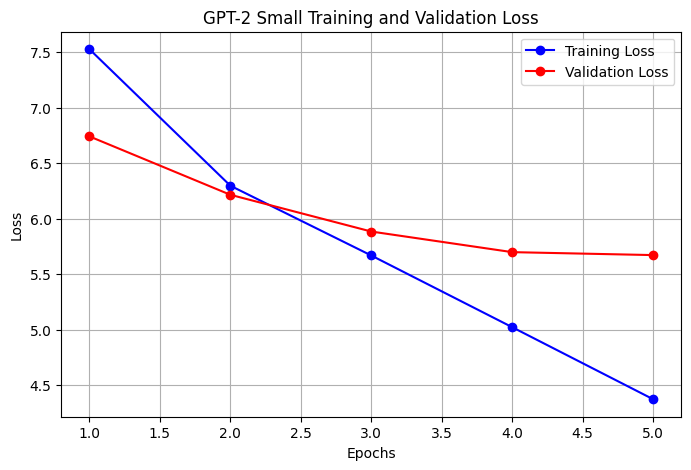

In [52]:

def plot_loss(train_losses, val_losses, title="GPT-2 Small Training and Validation Loss"):
    epochs = range(1, len(train_losses) + 1)  # Assuming losses are recorded per epoch

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses,color='blue',marker='o', label='Training Loss')
    plt.plot(epochs, val_losses,color = 'red',marker='o', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss(train_loss, val_loss)


In [53]:
# GPT-2 Medium hyperparameters
VOCAB_SIZE = 32000
EMBED_SIZE = 1024
NUM_LAYERS = 24
HEADS = 16
FORWARD_EXPANSION = 4
DROPOUT = 0.1
MAX_LENGTH = 128
BATCH_SIZE = 32
GRAD_ACCUMULATION_STEPS = 2
LEARNING_RATE = 2.5e-4
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 1000
EPOCHS = 5
TOTAL_TRAIN_STEPS = 10000


CHECKPOINT_INTERVAL = 500
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model with GPT-2 Small configuration using the GPT2Model class
medium_model = Decoder(
    vocab_size=VOCAB_SIZE,
    max_seq_length=MAX_LENGTH,
    embed_dim=EMBED_SIZE,
    num_heads=HEADS,
    num_layers=NUM_LAYERS,
    mlp_ratio=FORWARD_EXPANSION,
    dropout=DROPOUT
).to(DEVICE)

In [54]:
# Define new optimizer and scheduler for medium model
medium_optimizer = optim.AdamW(medium_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
medium_scheduler = get_cosine_schedule_with_warmup(
    medium_optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=TOTAL_TRAIN_STEPS
)


In [55]:

train_texts = [text for text in train_dataset["text"] if text.strip()]
val_texts = [text for text in val_dataset["text"] if text.strip()]
test_texts=[text for text in test_dataset["text"] if text.strip()]

train_data = TextDataset(train_texts, tokenizer)
val_data = TextDataset(val_texts, tokenizer)
test_data=TextDataset(test_texts,tokenizer)


# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)

In [56]:

# Call train_model function
medium_train_loss, medium_val_loss = train_model(train_loader, val_loader,
                                                 medium_model,
                                                 optimizer=medium_optimizer,
                                                 scheduler=medium_scheduler,
                                                 criterion=criterion,
                                                 num_epochs=EPOCHS,
                                                 grad_accum_steps=GRAD_ACCUMULATION_STEPS,
                                                 checkpoint_interval=CHECKPOINT_INTERVAL,
                                                 device=DEVICE,
                                                 vocab_size=VOCAB_SIZE)



Epoch 1 Training:  67%|██████▋   | 500/743 [04:35<05:05,  1.26s/it, loss=6.96]


Checkpoint saved at checkpoint_epoch1_step500.pt


Epoch 1 Training: 100%|██████████| 743/743 [06:47<00:00,  1.82it/s, loss=6.67]


Epoch 1 Training Loss: 7.5534


Epoch 1 Validation: 100%|██████████| 77/77 [00:13<00:00,  5.61it/s, val_loss=6.64]


Epoch 1 Validation Loss: 6.7643
Model saved at checkpoint_epoch1.pt


Epoch 2 Training:  67%|██████▋   | 500/743 [04:35<05:00,  1.24s/it, loss=6.11]


Checkpoint saved at checkpoint_epoch2_step500.pt


Epoch 2 Training: 100%|██████████| 743/743 [06:47<00:00,  1.82it/s, loss=6.21]


Epoch 2 Training Loss: 6.3575


Epoch 2 Validation: 100%|██████████| 77/77 [00:13<00:00,  5.61it/s, val_loss=6.08]


Epoch 2 Validation Loss: 6.2737
Model saved at checkpoint_epoch2.pt


Epoch 3 Training:  67%|██████▋   | 500/743 [04:35<04:52,  1.20s/it, loss=5.83]


Checkpoint saved at checkpoint_epoch3_step500.pt


Epoch 3 Training: 100%|██████████| 743/743 [06:47<00:00,  1.82it/s, loss=5.6]


Epoch 3 Training Loss: 5.7708


Epoch 3 Validation: 100%|██████████| 77/77 [00:13<00:00,  5.61it/s, val_loss=5.74]


Epoch 3 Validation Loss: 5.9334
Model saved at checkpoint_epoch3.pt


Epoch 4 Training:  67%|██████▋   | 500/743 [04:35<04:59,  1.23s/it, loss=5.18]


Checkpoint saved at checkpoint_epoch4_step500.pt


Epoch 4 Training: 100%|██████████| 743/743 [06:47<00:00,  1.82it/s, loss=4.92]


Epoch 4 Training Loss: 5.1790


Epoch 4 Validation: 100%|██████████| 77/77 [00:13<00:00,  5.61it/s, val_loss=5.49]


Epoch 4 Validation Loss: 5.7022
Model saved at checkpoint_epoch4.pt


Epoch 5 Training:  67%|██████▋   | 500/743 [04:35<04:59,  1.23s/it, loss=4.71]


Checkpoint saved at checkpoint_epoch5_step500.pt


Epoch 5 Training: 100%|██████████| 743/743 [06:47<00:00,  1.82it/s, loss=4.49]


Epoch 5 Training Loss: 4.5757


Epoch 5 Validation: 100%|██████████| 77/77 [00:13<00:00,  5.60it/s, val_loss=5.37]


Epoch 5 Validation Loss: 5.5833
Model saved at checkpoint_epoch5.pt
Training complete!


In [57]:
medium_evalute = evaluate_model(test_loader, model=medium_model, criterion=criterion)

Test Perplexity: 279.7835


In [61]:
prompt = "He had exam in a week"

# Generate text using different strategies
print("\n Greedy Decoding \n")
print(generate_sentence(prompt, medium_model, tokenizer, strategy="greedy"))

print("\n Top-k Sampling (k=50) \n")
print(generate_sentence(prompt, medium_model, tokenizer, strategy="top-k", top_k=50))

print("\n Nucleus Sampling (p=0.9) \n")
print(generate_sentence(prompt, medium_model, tokenizer, strategy="nucleus", top_p=0.9))


 Greedy Decoding 

He had exam in a week to return to the United States , and he was appointed the manager of the United States . He made his debut in a 1 – 0 defeat to the United States , which was a substitute for the season . He was promoted to the Premier League in the

 Top-k Sampling (k=50) 

He had exam in a week at the age of 15 , defeating the team as " the play @-@ off game on the screen line " . He was traded to the ball in the 1980 , and was scored 10 league for seven weeks before the season . He made his return to the

 Nucleus Sampling (p=0.9) 

He had exam in a week when he was charged with the 2007 FIFA World Cup squad , which went on to reach a match @-@ off @-@ final , making his injury career up to secure a midfielder with @-@ up aid ast te aring day before losing 21 against discuss a beat basis ,


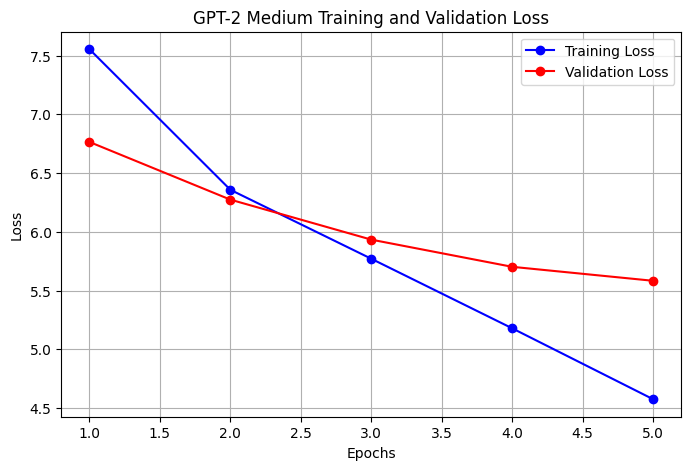

In [60]:
plot_loss(medium_train_loss, medium_val_loss,title="GPT-2 Medium Training and Validation Loss")